# Real projective coordinates on data set of image patches

In this example, we explore the topology of a collection of image patches capturing line segments, which, as we will show using persistent homology and projective coordinates, are parametrized by the projective plane $RP^2$.
Each image patch is a square $d \times d$ region of pixels.
Each pixel can be thought of as a dimension, so each patch lives in $\mathbb{R}^{d \times d}$, and a collection of patches can be thought of as a Euclidean point cloud in $\mathbb{R}^{d \times d}$.

In [1]:
import matplotlib.pyplot as plt

from ripser import ripser
from persim import plot_diagrams
from dreimac import ProjectiveCoords, GeometryUtils, GeometryExamples, PlotUtils, ProjectiveMapUtils

%load_ext autoreload
%autoreload 2

We now examine the collection of patches which hold oriented, slightly blurry line segments at varying distances from the center of the patch.
We start by considering a small sample of these patches.
Below, the "dim" variable sets the patch resolution, and the "sigma" variable sets the blurriness (a larger sigma means blurrier line segments). 

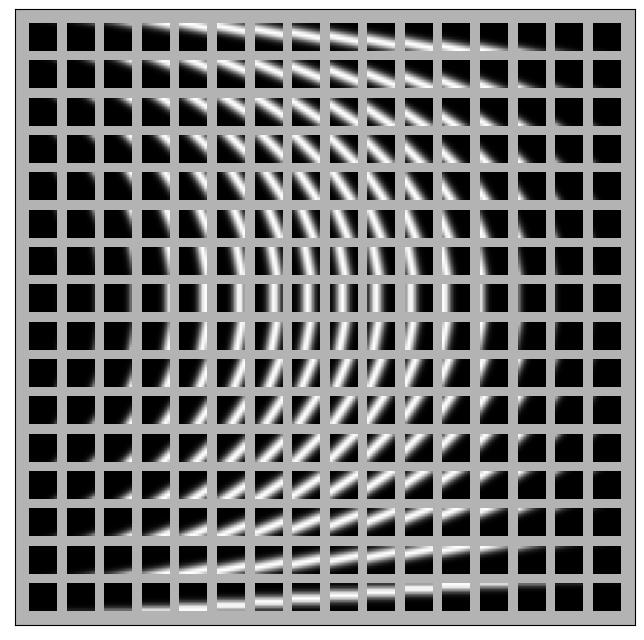

In [2]:
small_sample = GeometryExamples.line_patches(dim=10, n_angles=16, n_offsets=16, sigma=0.25)

plt.figure(figsize=(8, 8))
PlotUtils.plot_patches(small_sample, zoom=2)
plt.gca().set_facecolor((0.7, 0.7, 0.7))

Now let's compute persistence diagrams for this collection of patches with both $\mathbb{Z}/2$ coefficients and $\mathbb{Z}/3$ coefficients up to $H_2$.

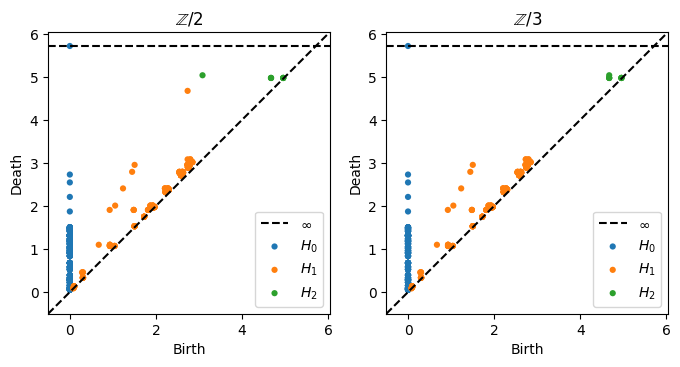

In [3]:
plt.figure(figsize=(8, 4))
for i,prime in enumerate([2,3]):
    pd = ripser(small_sample, coeff=prime, maxdim=2)['dgms']
    plt.subplot(1,2,i+1) ; plot_diagrams(pd) ; _ = plt.title("$\mathbb{Z}/" + str(prime) + "$")

There are two high-persistence classes in the persistence diagram with $\mathbb{Z}/2\mathbb{Z}$ coefficients that do not show up in the persistence diagram with $\mathbb{Z} / 3\mathbb{Z}$ coefficients.
This is the signature of the projective plane $RP^2$.
To verify this, we will map these patches to $RP^2$ using real projective coordinates.

In [14]:
X = GeometryExamples.line_patches(dim=10, n_angles=75, n_offsets=75, sigma=0.25)
#dist_mat = GeometryUtils.geodesic_distance_estimate(X, 20)

In [24]:
#dist_mat = GeometryUtils.geodesic_distance_estimate(X, 20)

import numpy as np
from scipy.spatial import KDTree
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import shortest_path


def landmark_geodesic_distance(X, n_landmarks, n_neighbors):
    spatial_tree = KDTree(X)
    distances_nn, indices_nn = spatial_tree.query(X,k=n_neighbors)
    # https://github.com/scikit-learn/scikit-learn/blob/364c77e047ca08a95862becf40a04fe9d4cd2c98/sklearn/neighbors/_base.py#L997
    n_queries = X.shape[0]
    n_nonzero = n_queries * n_neighbors
    indptr = np.arange(0, n_nonzero + 1, n_neighbors)
    kneighbors_graph = csr_matrix(
        (distances_nn.ravel(), indices_nn.ravel(), indptr), shape=(n_queries, n_queries)
    )

    # furthest point sampling
    n_points = X.shape[0]
    perm = np.zeros(n_landmarks, dtype=np.int64)
    lambdas = np.zeros(n_landmarks)
    ds = shortest_path(kneighbors_graph, indices = 0, directed=False)
    D = np.zeros((n_landmarks, n_points))
    D[0, :] = ds
    for i in range(1, n_landmarks):
        idx = np.argmax(ds)
        perm[i] = idx
        lambdas[i] = ds[idx]
        thisds  = shortest_path(kneighbors_graph, indices = idx, directed=False)
        D[i, :] = thisds
        ds = np.minimum(ds, thisds)
    Y = X[perm, :]

    perm_rest_points = np.setdiff1d(np.arange(0,n_points, dtype=int), perm, assume_unique=True)
    perm_all_points = np.concatenate((perm,perm_rest_points))

    return D[:,perm_all_points], perm_all_points

dist_mat, perm_all_points = landmark_geodesic_distance(X, 300, 20)
dist_mat.shape


(300, 5625)

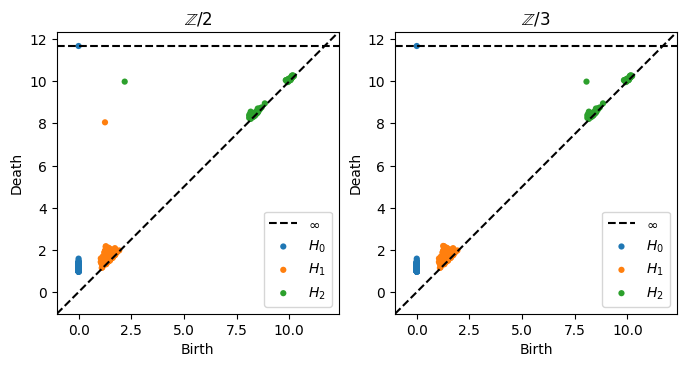

In [25]:
plt.figure(figsize=(8, 4))
for i,prime in enumerate([2,3]):
    pd = ripser(dist_mat[:,:dist_mat.shape[0]], coeff=prime, maxdim=2, distance_matrix=True)['dgms']
    plt.subplot(1,2,i+1) ; plot_diagrams(pd) ; _ = plt.title("$\mathbb{Z}/" + str(prime) + "$")

In [31]:
pc = ProjectiveCoords(dist_mat, n_landmarks=None, distance_matrix=True)
#pc = ProjectiveCoords(X, n_landmarks=200)
proj_coords = pc.get_coordinates(proj_dim=2, perc=0.8, cocycle_idx=0, projective_dim_red_mode="exponential")

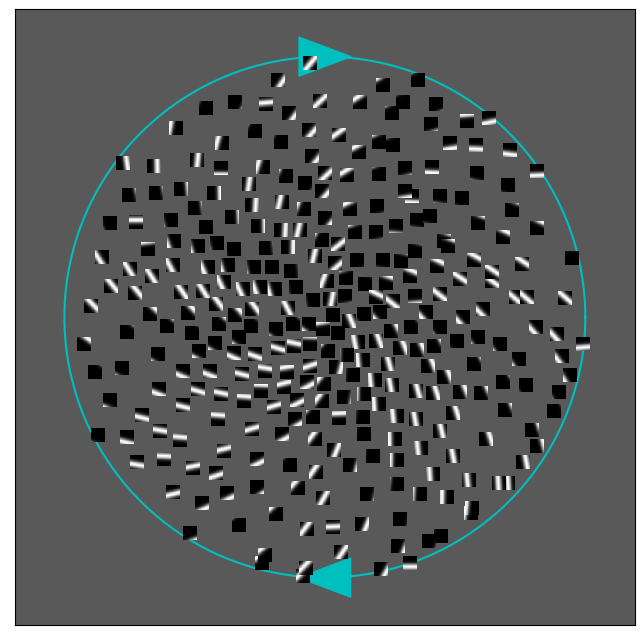

In [32]:
subsample = GeometryUtils.get_greedy_perm_pc(proj_coords, 300)['perm']
stereo_projection_dim_red_subsample = ProjectiveMapUtils.get_stereo_proj_codim1(proj_coords[subsample, :])

plt.figure(figsize=(8, 8))
PlotUtils.imscatter(stereo_projection_dim_red_subsample, X[subsample, :], 10)
_ = PlotUtils.plot_proj_boundary()